<a href="https://colab.research.google.com/github/sergekamanzi/Fraud-Detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving neural.png to neural (1).png


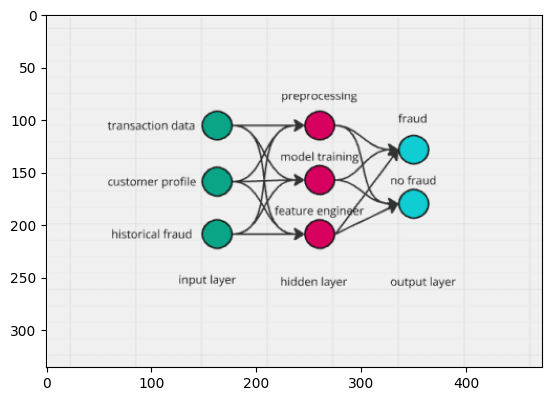

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()


image = Image.open('/content/neural.png')
plt.imshow(image)
plt.show()

In [1]:
import pandas as pd
import joblib
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import RMSprop
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

In [2]:
# Load Dataset
data = pd.read_csv('/content/fraud detection.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,380.0,CASH_OUT,92888.94,C2054348498,27657.00,0.00,C1853199806,5838781.76,5931670.70,0.0,0.0
1,646.0,TRANSFER,399045.08,C724693370,10399045.08,10399045.08,C1909486199,0.00,0.00,1.0,1.0
2,384.0,CASH_IN,35416.73,C1095508813,1154711.52,1190128.25,C961243143,927932.70,892515.97,0.0,0.0
3,518.0,CASH_IN,52211.31,C1867780533,2985.00,55196.31,C1425168473,433652.93,381441.62,0.0,0.0
4,450.0,CASH_OUT,1463764.35,C2142422300,1463764.35,0.00,C1173885211,385211.95,1848976.30,1.0,0.0


In [3]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

#adam and L2

In [5]:
# Custom Focal Loss Function
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = alpha * K.pow((1 - p_t), gamma)
        return focal_term * bce
    return loss

# Define the Advanced Neural Network Model with L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [6]:
%%capture
# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9820
F1 Score: 0.9698
Precision: 0.9502
Recall: 0.9903


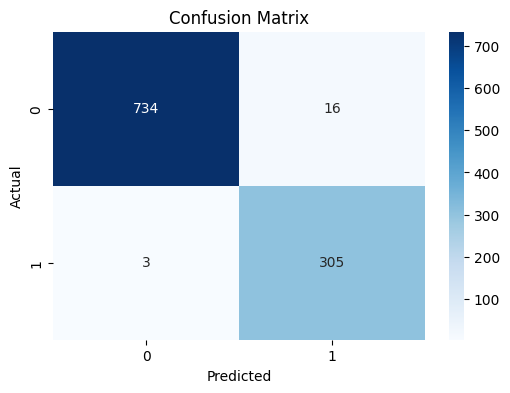

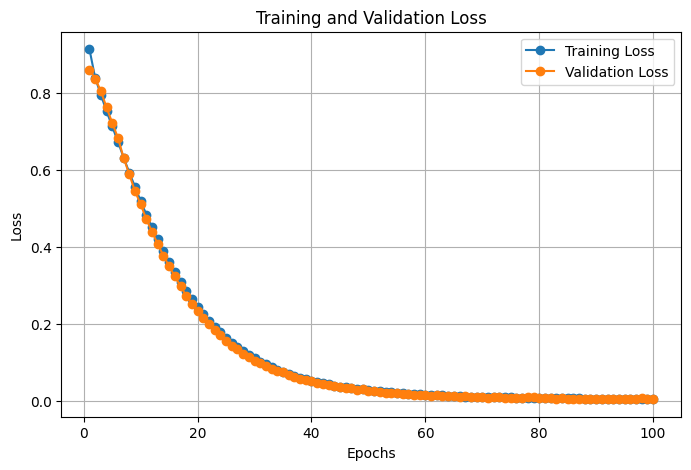

In [7]:
# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Adjust Classification Threshold Using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > best_threshold).astype("int32")

# Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Extract training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#RMSprop and L1

In [12]:
# Define the Advanced Neural Network Model with L1 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l1(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l1(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
%%capture
# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Accuracy: 0.9764
F1 Score: 0.9605
Precision: 0.9354
Recall: 0.9870


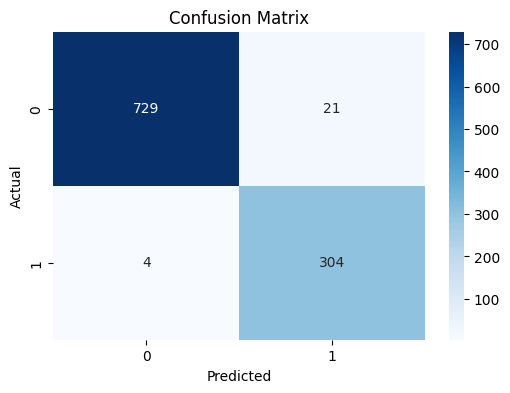

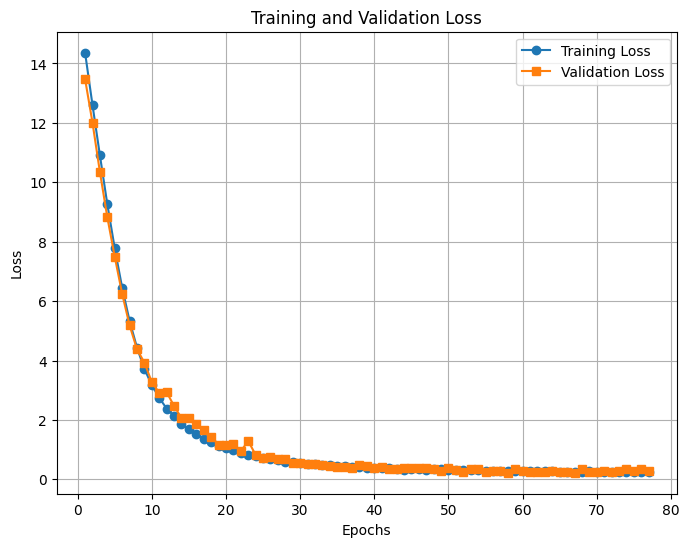

In [14]:

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#SDG and l1-l2

In [15]:
# Define the Advanced Neural Network Model with L1_L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
%%capture
# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9537
F1 Score: 0.9261
Precision: 0.8648
Recall: 0.9968


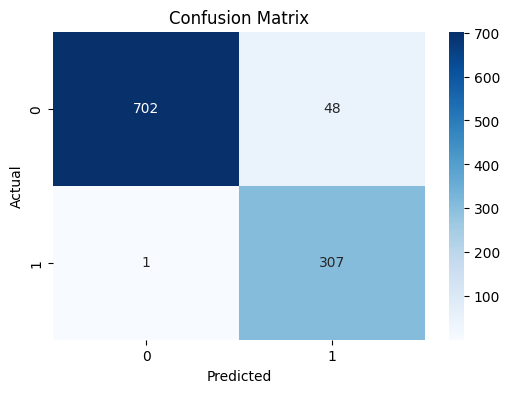

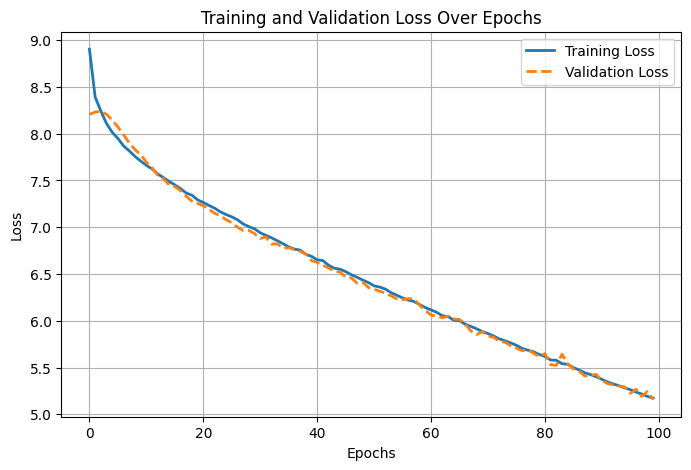

In [17]:
# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Extract loss and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2, linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#classical Logistic regression


Best Parameters: {'C': 100, 'solver': 'lbfgs'}
Accuracy: 0.9371
Precision: 0.8912
Recall: 0.8927
F1 Score: 0.8920


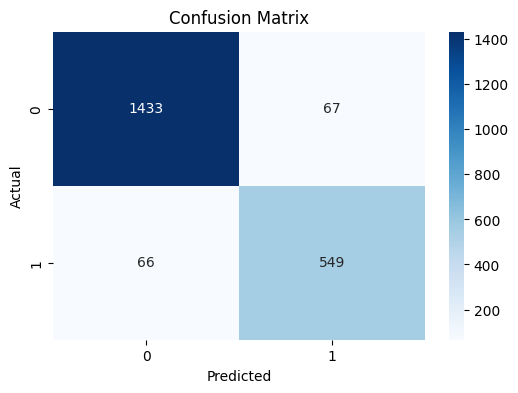

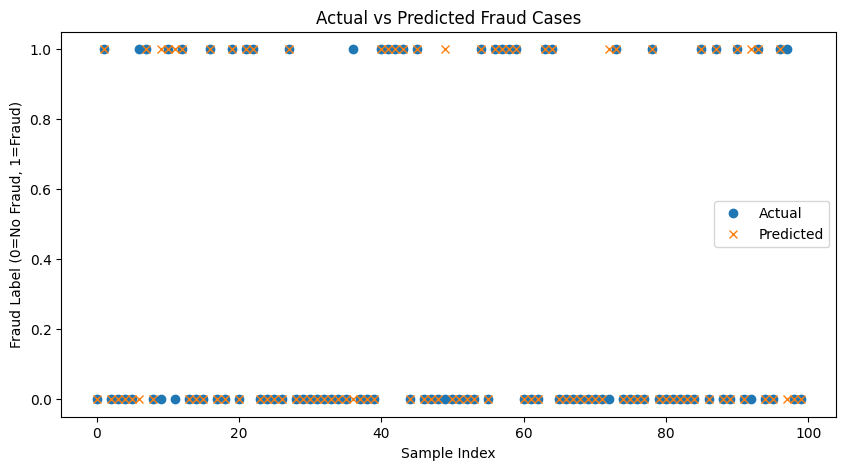

In [ ]:
# Feature Selection
selector = SelectKBest(f_classif, k=10)  # Keep 10 best features
X_selected = selector.fit_transform(X_scaled, Y)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=42, stratify=Y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, Y_train_resampled)
best_model = grid_search.best_estimator_

# Make predictions
Y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print evaluation metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10,5))
plt.plot(Y_test.values[:100], label="Actual", marker='o', linestyle="")
plt.plot(Y_pred[:100], label="Predicted", marker='x', linestyle="")
plt.xlabel("Sample Index")
plt.ylabel("Fraud Label (0=No Fraud, 1=Fraud)")
plt.title("Actual vs Predicted Fraud Cases")
plt.legend()
plt.show()


#A simple machine learning model without an optimizer

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6928 - loss: 0.6314 - val_accuracy: 0.7622 - val_loss: 0.5254
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7743 - loss: 0.5017 - val_accuracy: 0.8071 - val_loss: 0.4631
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8044 - loss: 0.4562 - val_accuracy: 0.8345 - val_loss: 0.4257
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8462 - loss: 0.4095 - val_accuracy: 0.8440 - val_loss: 0.3996
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8481 - loss: 0.3861 - val_accuracy: 0.8492 - val_loss: 0.3801
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8541 - loss: 0.3622 - val_accuracy: 0.8558 - val_loss: 0.3648
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8589 - loss: 0.3542 - val_accuracy: 0.8605 - val_loss: 0.3515
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8664 - loss: 0.3330 - val_accuracy: 0.8638 - val

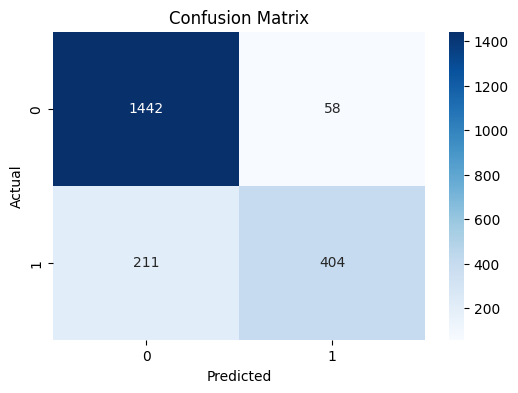

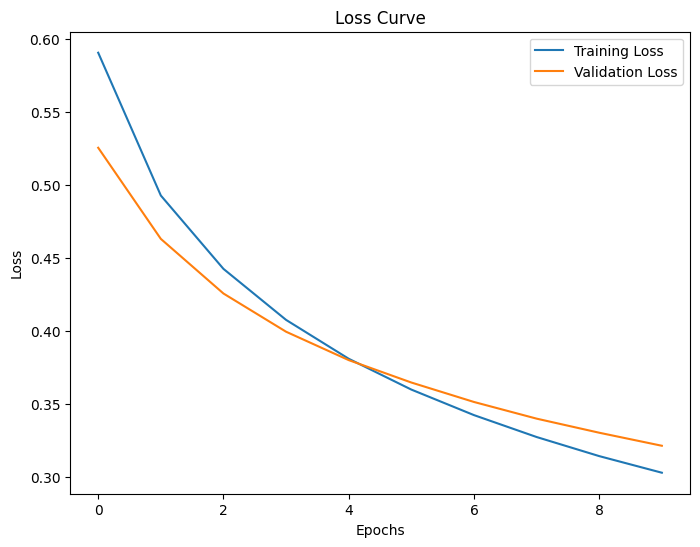

In [ ]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)

# Define a simple neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with default SGD optimizer
model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store training history
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32, verbose=1)

# Evaluate the model
final_accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
print(f"Final Model Accuracy on Test Data: {final_accuracy:.4f}")

# Make predictions
Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss Curve
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

#Nadam + l2

In [18]:
# Feature Shape
num_features = X_train_resampled.shape[1]
X_val = X_val[:, :num_features]
X_test = X_test[:, :num_features]

# Define the Advanced Neural Network Model with L2 Regularization
inputs = Input(shape=(num_features,))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [19]:
%%capture
# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9905
F1 Score: 0.9839
Precision: 0.9745
Recall: 0.9935


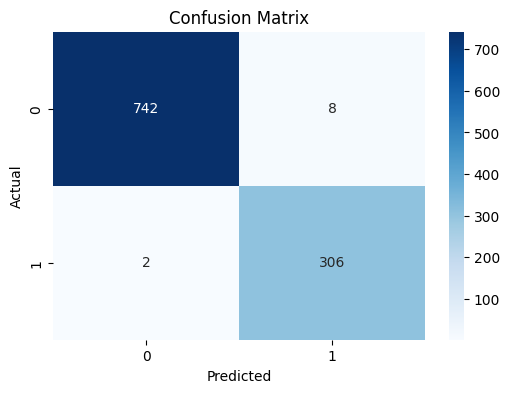

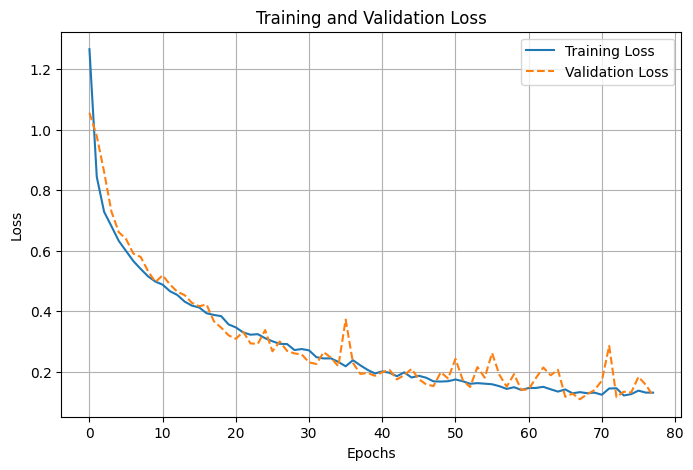

In [20]:
# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create the directory if it doesn't exist
model_dir = "saved_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# Save the Adam + L2 model
model.save(os.path.join(model_dir, "adam_l2_model.h5"))

# Save the RMSprop + L1 model
model.save(os.path.join(model_dir, "rmsprop_l1_model.h5"))

# Save the SGD + L1_L2 model
model.save(os.path.join(model_dir, "sgd_l1l2_model.h5"))

# Save the Nadam + L2 model
model.save(os.path.join(model_dir, "nadam_l2_model.h5"))

# Save the simple neural network without optimizer
model.save(os.path.join(model_dir, "simple_nn_no_optimizer.h5"))

# Save the trained Logistic Regression model
joblib.dump(best_model, os.path.join(model_dir, "logistic_regression_model.pkl"))

print("Savez Models:")
print(os.listdir(model_dir))



Savez Models:
['simple_nn_no_optimizer.h5', 'sgd_l1l2_model.h5', 'adam_l2_model.h5', 'logistic_regression_model.pkl', 'rmsprop_l1_model.h5', 'nadam_l2_model.h5']
